In [1]:
import sys

if "/Users/shvimas/GitHub/diploma/src" not in sys.path:
    sys.path.append("/Users/shvimas/GitHub/diploma/src")

In [2]:
%matplotlib inline
import matplotlib.pyplot as pl
import data_helpers as dh
import heston_pricing as he
from pars_range import Range
from importlib import reload, _RELOADING


pl.rcParams["figure.figsize"] = (15, 10)

In [3]:
pl.rcParams["figure.figsize"] = (15, 10)

In [4]:
try:
    data, info = dh.read_data("../SPH2_031612.csv")
except FileNotFoundError:
    data, info = dh.read_data("SPH2_031612.csv")

In [5]:
data, info = dh.prepare_data(data=data, info=info)

In [6]:
num = 20
kappa_range = Range(min=2, max=10, num=num)
theta_range = Range(min=1e-6, max=1, num=num)
sigma_range = Range(min=1e-6, max=1, num=num)
rho_range = Range(min=0, max=1, num=num)
v0_range = Range(min=1e-6, max=1, num=num)

In [7]:
day = 0
rate = .03
q = rate
maturity = info[day].mat / len(info)
spot = info[day].spot
is_call = True
strikes = data.strikes[is_call][day]
prices = data.prices[is_call][day]

args = (spot, strikes, maturity, rate, q, is_call)

In [8]:
pars = (4.2216740989, 0.0199176675743, 1.51769128617e-05, 0.0474806534178, 0.000569295223402)

kappa_range[0], *pars[1:]


(2.0, 0.0199176675743, 1.51769128617e-05, 0.0474806534178, 0.000569295223402)

In [11]:
predicted_kappa = []
kappas = kappa_range
for kappa in kappas:
    pars = kappa, *(pars[1:])
    x = strikes
    y = he.price_heston(pars=pars, args=args)
    predicted_kappa.append(x)
    predicted_kappa.append(y)

kappas[:]

[2.0,
 2.4210526315789473,
 2.8421052631578947,
 3.263157894736842,
 3.6842105263157894,
 4.105263157894736,
 4.526315789473684,
 4.947368421052632,
 5.368421052631579,
 5.789473684210526,
 6.2105263157894735,
 6.631578947368421,
 7.052631578947368,
 7.473684210526315,
 7.894736842105263,
 8.31578947368421,
 8.736842105263158,
 9.157894736842104,
 9.578947368421051,
 10.0]

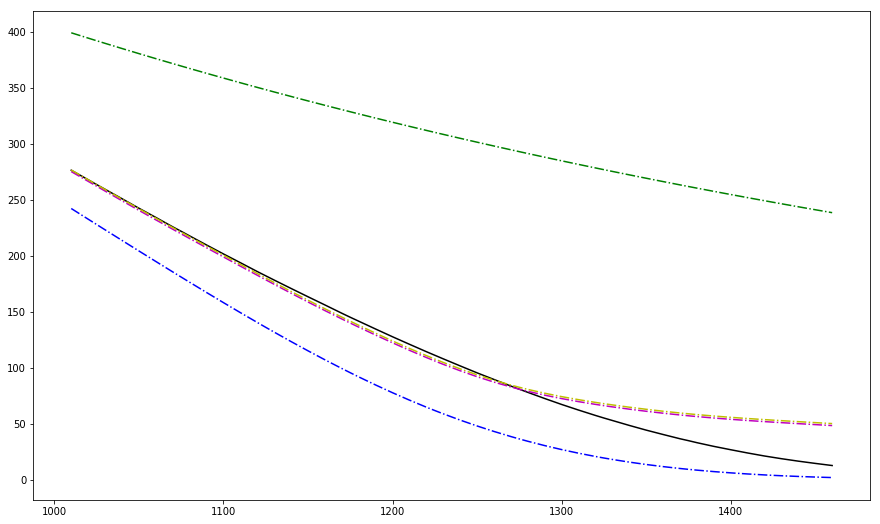

In [22]:
p = pl.plot(  # *predicted_kappa, 
    strikes, data.prices[is_call][day], "k-",
    strikes, he.price_heston(args=args, pars=(9.694173546591017, 0.24630610188128582, 0.8332571621596554, 
                                              0.9693685064163662, 0.4801388745409953)), "g-.",
    strikes, he.price_heston(args=args, pars=(5.10944827e+00, 5.93251547e-03, 2.81152494e-05,
                                              4.93769921e-02, 1.01083722e-03)), "b-.",
    strikes, he.price_heston(args=args, pars=(0.07113125,  0.11028212,  2.0111178,  
                                              0, 0.09534668)), "m-.",
    strikes, he.price_heston(args=args, pars=(0.03004374455815602, 0.02711322443113005, 1.9746283135615887, 
                                              0.00019123809579942708, 0.10315832344591712)), "y-.")

In [19]:
from structs import EvalArgs


new_args = EvalArgs.from_tuple(args)
new_args.r = .001
new_args.q = .001
predicted = he.price_heston(args=new_args.as_tuple(), 
                            pars=(9.694173546591017, 0.24630610188128582, 0.8332571621596554, 
                                  0.9693685064163662, 0.4801388745409953))

In [20]:
from optimization import robust_mean_ratio

robust_mean_ratio(predicted, prices)

4.399280350915767

In [11]:
from importlib import reload
import heston_pricing as he
from structs import EvalArgs
import modeling
modeling = reload(modeling)
he = reload(he)

In [18]:
res = modeling.tune_model(args=EvalArgs.from_tuple(args),
                          model="heston", metric="MAR", prices=prices, 
                          bounds=((.01, 6), (.0001, 1), (1.5e-7, 3), (0, 1), (5e-6, 1)))


In [19]:
res

     fun: 1.0884918034416657
     jac: array([ 0.00170992,  0.07555159, -0.00034515,  0.13998096,  0.06375647])
 message: 'Optimization terminated successfully.'
    nfev: 2175
     nit: 24
 success: True
       x: array([ 0.8394815 ,  0.03088356,  2.57097933,  0.        ,  0.11774668])

In [23]:
from optimization import mean_absolute_error
predicted = he.price_heston(pars=(2.76000138e-01, 1.00000000e-04, 8.19074054e-01, 1.00000000e+00, 1.00000000e-01),
                            args=args)
mean_absolute_error(predicted, prices)
predicted.flatten().shape


(45,)

In [10]:
res = modeling.tune_model(args=EvalArgs.from_tuple(args),
                          model="heston", metric="MAE", prices=prices, 
                          bounds=((.1, 6), (.0001, .03), (1.5e-7, 3), (0, 1), (5e-6, 1e-1)))


In [11]:
res

     fun: 4.986386452082709
     jac: array([  0.75808275,  -0.03873213,  -0.02673097,  10.08315769,   1.26953514])
 message: 'Optimization terminated successfully.'
    nfev: 4179
     nit: 50
 success: True
       x: array([ 0.10620628,  0.02527766,  1.80945962,  0.        ,  0.09975204])

In [22]:
%reload_ext autoreload

In [23]:
%autoreload

In [8]:
import warnings
warnings.filterwarnings("ignore", message='numpy.dtype size changed')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings('ignore', message="can't resolve package from __spec__ or __package__, ")

In [9]:
import data_helpers as dh
import numpy as np
import sklearn.decomposition as de


dh = reload(dh)
print(_RELOADING)


filename1 = dh.get_filename(model='heston', metric='MAE', is_call=True)
filename2 = dh.get_filename(model='heston', metric='MAE', is_call=False)
centers1 = np.array(list(dh.extract_centers(filename1)))
centers2 = np.array(list(dh.extract_centers(filename2)))
pca1 = de.PCA(n_components=2, whiten=True)
pca1.fit(centers1)
print(pca1.explained_variance_ratio_)
components1 = pca1.components_
pca2 = de.PCA(n_components=2, whiten=True)
pca2.fit(centers2)
print(pca2.explained_variance_ratio_)
components2 = pca2.components_

{}
[ 0.9831441   0.01434402]
[ 0.93347398  0.06598476]


30

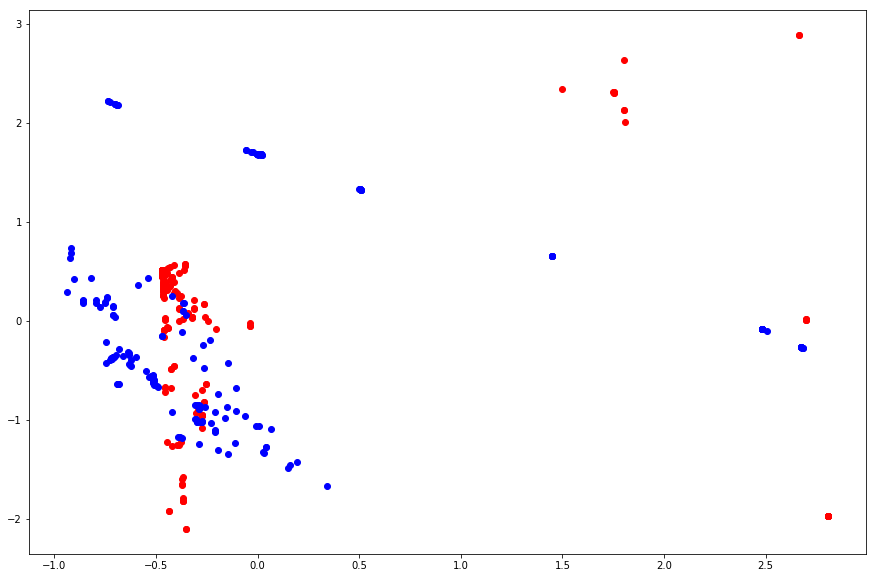

In [10]:
centers_2d_1 = pca1.fit_transform(centers1)
centers_2d_2 = pca2.fit_transform(centers2)
dh.plot_dots(a=centers_2d_1, b=centers_2d_2)

sum(list(map(
    lambda x: he.bad_pars(*x, bounds_only=True),
    centers_2d_1 @ components1 + pca1.mean_
)))

In [11]:
def restore_pars(dots, factors, means):
    return dots @ factors + means


centers2 - restore_pars(centers_2d_2, components2, pca2.mean_)

q = list(map(lambda x: he.bad_pars(*x, bounds_only=True), centers1))
sum(q) / len(q)

[[  9.93390453e-01  -4.40704554e-04  -1.14266703e-01   8.25110732e-03
   -7.08903113e-03]
 [  1.13629861e-01  -1.10060093e-01   9.87188568e-01   2.65404358e-03
    2.06571539e-02]]
[[ 0.98235659 -0.00482655 -0.18662036  0.00502411 -0.00999191]
 [-0.18682507  0.01813953 -0.98036381  0.01502615 -0.05855222]]


In [12]:
print(components1)
print(components2)

[[  9.93390453e-01  -4.40704554e-04  -1.14266703e-01   8.25110732e-03
   -7.08903113e-03]
 [  1.13629861e-01  -1.10060093e-01   9.87188568e-01   2.65404358e-03
    2.06571539e-02]]
[[ 0.98235659 -0.00482655 -0.18662036  0.00502411 -0.00999191]
 [-0.18682507  0.01813953 -0.98036381  0.01502615 -0.05855222]]


In [20]:
import data_helpers as dh
with open('params/pca_heston.txt', 'w') as f:
    f.writelines([f"{1e-10}, {200}, {-2}, {1.5}\n",
                  f"[{dh.array2str(components1[0])}], [{dh.array2str(components1[1])}]\n",
                  f"{dh.array2str(pca1.mean_)}\n",
                  f"{1e-10}, {200}, {-2}, {1.5}\n",
                  f"[{dh.array2str(components2[0])}], [{dh.array2str(components2[1])}]\n",
                  f"{dh.array2str(pca2.mean_)}\n"])

In [24]:
dots = dh.gen2list(dh.extract_centers(dh.get_filename(model='heston', metric='MAE', is_call=True,
                                                      from_dir='params', best=True)))

In [27]:
plots = []
for p in dots:
    plots.append(strikes)
    plots.append(he.price_heston(pars=p, args=args))

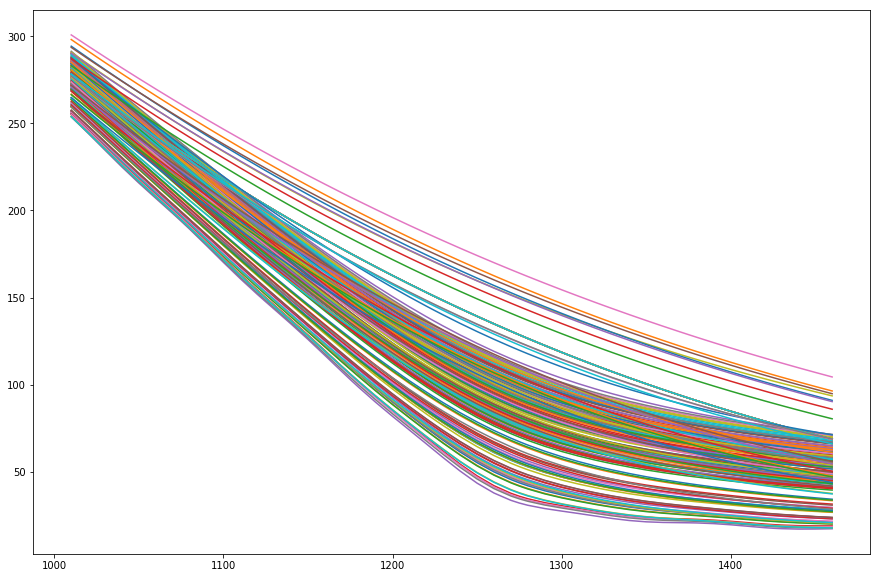

In [29]:
p = pl.plot(*plots)

In [108]:
%autoreload

In [104]:
for d in dots:
    print(d)

NameError: name 'dots' is not defined

In [11]:
import numpy as np
grid = np.array(dh.grid(-2, 14, -2, 1, n=50))

In [12]:
restored = np.array(list(map(
    lambda dot: dot @ components1 + pca1.mean_,
    grid
)))

In [13]:
dh = reload(dh)
print(_RELOADING)
restored.shape
centers_2d_1.shape

{}


(187, 2)

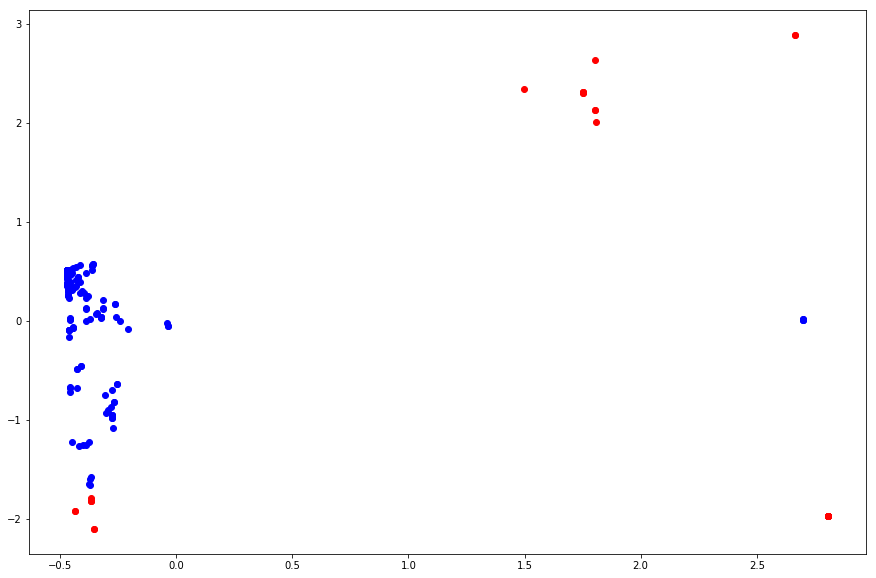

In [14]:
is_bad = np.array(list(map(
    lambda x: dh.bad_pars(x, bounds_only=True, model='heston'),
    restored
)))

good = np.array(grid)[np.logical_not(is_bad)]
bad = np.array(grid)[is_bad]
dh.plot_and_color_2d_params(model='heston', dots=centers_2d_1, factors=components1, means=pca1.mean_)
#dh.plot_dots(a=centers_2d_1, style1='go')

In [15]:
sum(is_bad) / len(grid)

0.58323721645520954

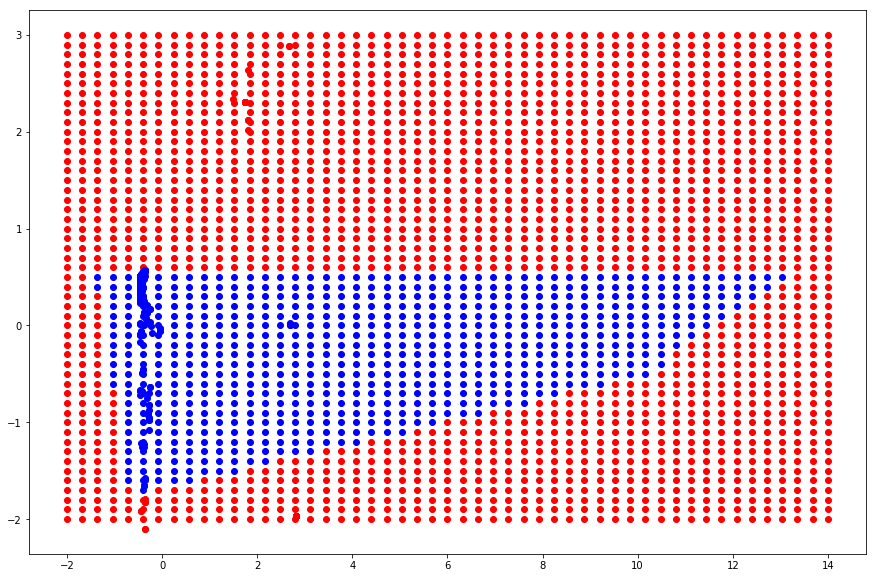

In [32]:
grid = np.array(dh.grid(-2, 14, -2, 3, n=50))

dh.plot_and_color_2d_params(model='heston', dots=grid, factors=components1, 
                            means=pca1.mean_, bounds_only=True)
dh.plot_and_color_2d_params(model='heston', dots=centers_2d_1, factors=components1, 
                            means=pca1.mean_, bounds_only=True)

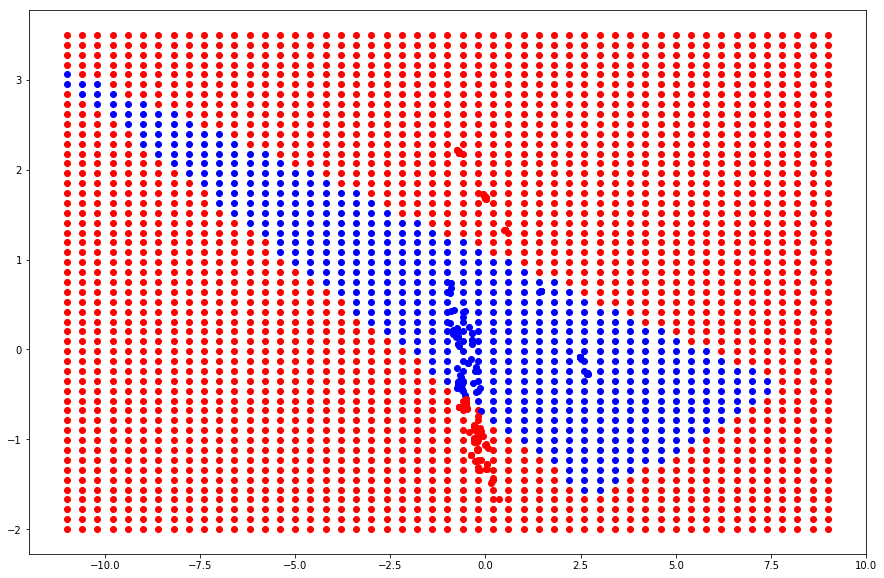

In [43]:
grid = np.array(dh.grid(-11, 9, -2, 3.5, n=50))

dh.plot_and_color_2d_params(model='heston', dots=grid, factors=components2, 
                            means=pca2.mean_, bounds_only=True)
dh.plot_and_color_2d_params(model='heston', dots=centers_2d_2, factors=components2, 
                            means=pca2.mean_, bounds_only=True)

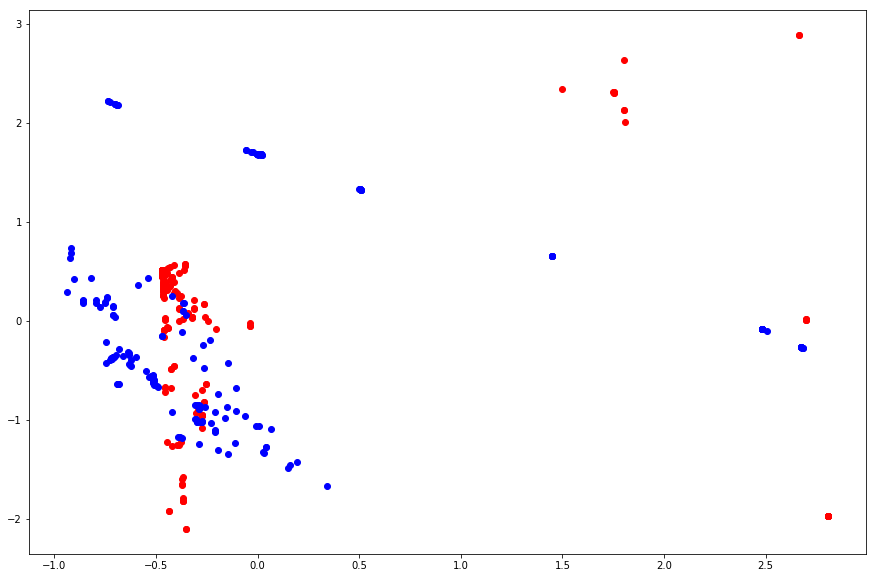

In [65]:
dh.plot_dots(centers_2d_1, centers_2d_2)

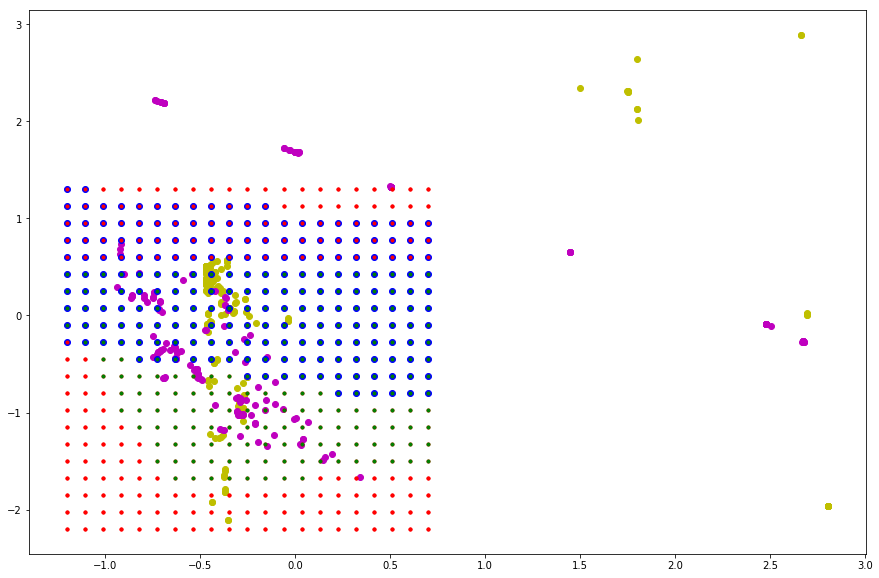

In [74]:
common_grid = np.array(dh.grid(-1.2, .7, -2.2, 1.3, n=20))

dh.plot_dots(centers_2d_1, centers_2d_2, style1='yo', style2='mo')
dh.plot_and_color_2d_params(model='heston', dots=common_grid, 
                            factors=pca2.components_, means=pca2.mean_,
                            style_good='bo', style_bad='r.', bounds_only=True)
dh.plot_and_color_2d_params(model='heston', dots=common_grid, 
                            factors=pca1.components_, means=pca1.mean_, 
                            style_good='g.', style_bad='r.', bounds_only=True)


In [43]:
dummy = np.array([np.array([1, 2, 3]) * i for i in range(101)])

In [49]:
pca = de.PCA(n_components=2)
dummy_2d = pca.fit_transform(dummy)
dummy_2d @ pca.components_ + pca.mean_ - dummy

array([[  0.00000000e+00,   0.00000000e+00,   5.68434189e-14],
       [  7.10542736e-15,   1.42108547e-14,   2.84217094e-14],
       [  7.10542736e-15,   1.42108547e-14,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.10542736e-15,   1.42108547e-14,   2.84217094e-14],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.10542736e-15,   1.42108547e-14,   1.42108547e-14],
       [  0.00000000e+00,   0.00000000e+00,  -1.42108547e-14],
       [  7.10542736e-15,   1.42108547e-14,   1.42108547e-14],
       [  0.00000000e+00,   0.00000000e+00,   1.42108547e-14],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.10542736e-15,   1.42108547e-14,   2.84217094e-14],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.10542736e-15,   1.42108547e-14,   1.4210854

In [94]:
np.array([1.8, 2.5]) @ pca1.components_ + pca1.mean_

array([ 3.44056493, -0.21251266,  3.92647231,  0.03168641,  0.12153246])